#
We run ROAD (faithfulness) from Quantus on RISE and a random baseline and get unexplainable bad results.

In [1]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
import dianna
import quantus

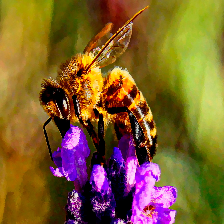

In [2]:
def load_img(path, target_size):
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications.resnet50 import preprocess_input
    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

bee_img, bee_arr = load_img('C:/Users/ChristiaanMeijer/OneDrive - Netherlands eScience Center/Documents/dianna/dianna-exploration/example_data/xai_method_study/RISE/bee.jpg', (224,224,3))
bee_img

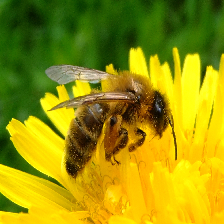

In [3]:
from pathlib import Path

reference_img, reference_arr = load_img(
    Path(r'C:\Users\ChristiaanMeijer\OneDrive - Netherlands eScience Center\Documents\dianna\dianna-exploration\notebooks_for_distance_explainer\data\bee2.jpg'),
    (224, 224, 3))
reference_img


In [4]:
import matplotlib.pyplot as plt

def plot_hist(result):
    data = []
    for key, value in result.items():
        for _ in range(int(value)):
            data.append(key)

    # plot the histogram
    plt.hist(data, bins=range(0, 101, 10), align='mid')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Results')
    plt.show()

In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
model = ResNet50()

def random_xai(model, input_data, method, labels, **kwargs):
    output = np.random.randn(*input_data.shape[:-1])[None,...]
    return output

random_result = quantus.AvgSensitivity(
    nr_samples=50,
    # perturb_func=quantus.perturb_func.gaussian_noise,
)(model=model,
   x_batch=bee_arr,
   y_batch=[309],
   a_batch=None,
   explain_func= random_xai,
   explain_func_kwargs={'model_or_function': model,
                        "input_data": bee_arr[0],
                        "method": "RISE",
                        "labels": range(1),
                       }
)
print(random_result)


[1.4153365266609015]


In [6]:
random_result

[1.4173903186798795]

In [9]:
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50
from distance_explainer.distance import DistanceExplainer, generate_masks_for_images
model = ResNet50()
embedded_reference = model(reference_arr)

class OurModel(tensorflow.keras.Model):
    def call(self, input_arr):
        input_prediction = model(input_arr)
        distances = DistanceExplainer.calculate_distances(input_prediction, embedded_reference)
        return distances

img_shape = bee_arr.shape[1:3]
n_masks = 500
masks = generate_masks_for_images(img_shape, n_masks, 0.5, 8)
distance_model = OurModel()
targets = distance_model(bee_arr)

channel_first = True  # transpose to always have channels first (pytorch style)

def explain(model, inputs, targets, **kwargs) -> np.ndarray:
    """

    :param model:
    :param inputs:
    :param targets: Ignored, added because of required signature (source: https://captum.ai/api/gradient_shap.html#captum.attr.GradientShap.attribute)
    :param kwargs:
    :return:
    """

    if channel_first:
        inputst = inputs.transpose([0,2,3,1])
    else:
        inputst = inputs

    # see C:\Users\ChristiaanMeijer\anaconda3\envs\distance_explainer311\Lib\site-packages\quantus\functions\explanation_func.py
    batch_size = inputst.shape[0]
    saliencies = np.empty(inputst.shape)
    for i in range(batch_size):
        saliencies[i], _ = DistanceExplainer(axis_labels=['x','y','channels'], n_masks=n_masks).explain_image_distance(model, inputst[i], embedded_reference, masks=masks)

    # See quantus\metrics\base.py:l425 Channels first!
    if channel_first:
        return saliencies.transpose([0,3,1,2])
    else:
        return saliencies

In [10]:
from pandas import DataFrame

if True:
    x_batch = bee_arr.transpose([0,3,1,2])
else:
    x_batch = bee_arr

result = []
for i in range(20):
    result.append(quantus.AvgSensitivity(
        nr_samples=1,
        perturb_func_kwargs={'perturb_std':0.1*255,},
        # perturb_func=quantus.perturb_func.gaussian_noise,
    )(model=model,

       x_batch=x_batch,
       y_batch=[0],
       a_batch=None,
       channel_first=channel_first,
       explain_func=explain,  #model, inputs, targets, kwargs
    ))
r_df = DataFrame(result)
print(r_df)
print(r_df.describe())


Explaining: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


               0
0   4.553029e-02
1   6.196491e-02
2   3.208585e-07
3   3.225280e-07
4   4.100401e-02
5   4.100400e-02
6   4.100400e-02
7   5.491639e-02
8   6.009225e-02
9   2.970153e-07
10  6.819321e-02
11  4.100401e-02
12  6.009224e-02
13  5.679272e-02
14  3.060886e-07
15  4.382211e-02
16  5.491638e-02
17  5.491639e-02
18  4.100401e-02
19  5.539613e-02


,0
count,2.000000e+01
mean,4.108271e-02
std,2.259242e-02
min,2.970153e-07
25%,4.100400e-02
50%,4.467620e-02
75%,5.574528e-02
max,6.819321e-02


In [11]:
print(r_df.describe())

                  0
count  2.000000e+01
mean   4.108271e-02
std    2.259242e-02
min    2.970153e-07
25%    4.100400e-02
50%    4.467620e-02
75%    5.574528e-02
max    6.819321e-02
